**Objective**:
### 1. Use dlib Face Detector 
### 2. Align the face using 5-pt detector and align (take a 5 second video of your face with some translation and rotation (not extreme)
### 3. Calculate 68-pt landmark on the aligned faces
### 4. Calculate the optical flow for these 68-pts every frame
### 5. Stabilize the optical flow using LK method as we discussed. 
### 6. Create a 5 second video, with three windows:

> a. Original frame

> b. Aligned Frame

> c. Aligned Frame with unstabilized points

> d. Aligned Frame with stabilzed points. 

### 7. Final video is 5 seconds and we need to see all 3 videos side by side for comparison. 
### 8. Upload to youtube, and embed the video in your readme file. 

In [1]:
!git clone https://github.com/vinayakumarvs/FaceDetector.git

Cloning into 'FaceDetector'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 73 (delta 15), reused 28 (delta 6), pack-reused 21
Unpacking objects: 100% (73/73), done.


In [2]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Mar  1 14:22 .
drwxr-xr-x 1 root root 4096 Mar  1 14:21 ..
drwxr-xr-x 1 root root 4096 Feb 19 17:12 .config
drwxr-xr-x 6 root root 4096 Mar  1 14:22 FaceDetector
drwxr-xr-x 1 root root 4096 Feb  5 18:37 sample_data


In [3]:
!ls ./FaceDetector/models/

shape_predictor_5_face_landmarks.dat  shape_predictor_68_face_landmarks.dat


In [4]:
!ls ./FaceDetector/input_video

mobile_video.mov  NewsReading.mov  video.mp4


In [5]:
!nvidia-smi

Sun Mar  1 14:22:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import dlib
import cv2
import numpy as np
import matplotlib
import os
import copy
import math, sys 

from FaceDetector.util import faceBlendCommon as fbc
from FaceDetector.util.vidtool import make_video_from_image_directory
from FaceDetector.util.vidtool import make_video
from FaceDetector.util.vidtool import concat_tile_resize

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

# save all images to disk
def save_all_images(path, filename, imageList):
  for cnt in range(0, len(imageList)):
    temp_fn = filename + '_' + str(cnt) + '.png'
    fn = os.path.join(path) + os.path.join(temp_fn)
    cv2.imwrite(fn, imageList[cnt])
    
# read all imagesread_all_images
def read_all_images(dir, filename_prefix, num_files):
  result_list = []
  for cnt in range(0, num_files):
    fn = filename_prefix + '_' + str(cnt) + '.png'
    full_path = os.path.join(dir, fn)
    img = cv2.imread(full_path)
    result_list.append(img)
    
  return result_list

In [9]:
videoFileName = './FaceDetector/input_video/mobile_video.mov'

# process the video frame by frame
cap = cv2.VideoCapture(videoFileName)

all_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()

    if frame is None:
      break

    all_frames.append(frame)
    #plt.imshow(frame)

cap.release()
print("Video frames", len(all_frames) )
all_frames[0].shape

Video frames 118


(640, 352, 3)

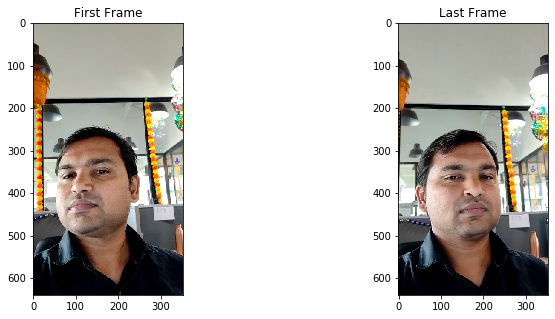

In [10]:
fig = plt.figure(figsize=(12, 5)) # width,height  
       
# Plot one original and aligned image
sub = fig.add_subplot(1, 2, 1) # nrows, ncols, index
sub.set_title("First Frame")
sub.imshow(all_frames[0][:,:,::-1])

sub = fig.add_subplot(1, 2, 2) # nrows, ncols, index
sub.set_title("Last Frame")
sub.imshow(all_frames[len(all_frames)-1][:,:,::-1])

In [0]:
!mkdir -p ./result/original

In [12]:
save_all_images('./result/original/', 'frame', all_frames)
!ls -al ./result/

total 12
drwxr-xr-x 3 root root 4096 Mar  1 14:23 .
drwxr-xr-x 1 root root 4096 Mar  1 14:23 ..
drwxr-xr-x 2 root root 4096 Mar  1 14:23 original


In [0]:
!mkdir -p ./result/final_frame
!mkdir -p ./result/output_video

In [0]:
def align_image_using_5point_detection(face_detector, land_mark_detector, im, height_output, width_output):

    # Detect landmarks.
    points = fbc.getLandmarks(face_detector, land_mark_detector, im)

    points = np.array(points)

    # Convert image to floating point in the range 0 to 1
    im = np.float32(im)/255.0

    # Normalize image to output coordinates.
    imNorm, points = fbc.normalizeImagesAndLandmarks((im.shape[0], im.shape[1]), im, points)

    imNorm = np.uint8(imNorm*255)

    return imNorm

# Function to calculate the intereye distance.
def interEyeDistance(predict):
    leftEyeLeftCorner = (predict[36].x, predict[36].y)
    rightEyeRightCorner = (predict[45].x, predict[45].y)
    distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
    distance = int(distance)
    return distance

In [0]:

# MODEL DATA PATH
MODEL_PATH = './FaceDetector/models'

# Landmark model location
PREDICTOR_PATH = os.path.join(MODEL_PATH, 'shape_predictor_68_face_landmarks.dat')

# Landmark model location
PREDICTOR_PATH_5POINT = os.path.join(MODEL_PATH, 'shape_predictor_5_face_landmarks.dat')


# Final frames
FINAL_FRAMES_PATH = './result/final_frame'

# Output Video path
OUTPUT_VIDEO_PATH = './result/output_video'

In [0]:
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)
land_mark_detector_5point = dlib.shape_predictor(PREDICTOR_PATH_5POINT)

In [0]:
RESIZE_HEIGHT = 480

eyeDistanceNotCalculated = True
eyeDistance = 0
fps = 30
count = 0

winSize = 101
maxLevel = 5

# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

In [0]:
# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
    print("Unable to load video")

In [21]:
while(True):

    # Grab a frame
    ret, im = cap.read()

    # Bail out when the video file ends
    if not ret:
        break

    # Finding the size of the image.
    size = im.shape[0:1]

    # Keeeping Original frame
    im_original = copy.deepcopy(im)
    cv2.putText(im_original, "Original", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

    count += 1
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # COnverting to grayscale
    imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    height = im.shape[0]
    IMAGE_RESIZE = float(height)/RESIZE_HEIGHT

    # Resize image for faster face detection
    imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
    imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)

    img_aligned = align_image_using_5point_detection(detector, land_mark_detector_5point, im, None, None)
    cv2.putText(img_aligned, "Aligned".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

    faces = detector(imSmallDlib, 0)

    # If no face was detected
    if len(faces) == 0:
        print("No face detected")
    else:
        for i in range(0, len(faces)):

            # Face detector was found over a smaller image.
            # So, we scale face rectangle to correct size.
            newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
                int(faces[i].top() * IMAGE_RESIZE),
                int(faces[i].right() * IMAGE_RESIZE),
                int(faces[i].bottom() * IMAGE_RESIZE))

            # Detect landmarks in current frame
            landmarks = landmarkDetector(imDlib, newRect).parts()

            # Handling the first frame of video differently,for the first frame copy the current frame points
            if (count == 1):
                pointsPrev=[]
                pointsDetectedPrev = []
                [pointsPrev.append((p.x, p.y)) for p in landmarks]
                [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]
            # If not the first frame, copy points from previous frame.
            else:
                pointsPrev=[]
                pointsDetectedPrev = []
                pointsPrev = points
                pointsDetectedPrev = pointsDetectedCur

            # pointsDetectedCur stores results returned by the facial landmark detector
            # points stores the stabilized landmark points
            points = []
            pointsDetectedCur = []
            [points.append((p.x, p.y)) for p in landmarks]
            [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

            # Convert to numpy float array
            pointsArr = np.array(points, np.float32)
            pointsPrevArr = np.array(pointsPrev, np.float32)

        # If eye distance is not calculated before
        if eyeDistanceNotCalculated:
            eyeDistance = interEyeDistance(landmarks)
            eyeDistanceNotCalculated = False

        if eyeDistance > 100:
            dotRadius = 3
        else:
            dotRadius = 2

        sigma = eyeDistance * eyeDistance / 400
        s = 2 * int(eyeDistance/4)+1

        #  Set up optical flow params
        lk_params = dict(winSize  = (s, s), maxLevel = maxLevel, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
        pointsArr, status, err = cv2.calcOpticalFlowPyrLK(im, imDlib, pointsPrevArr, pointsArr, **lk_params) 

        # Converting to float
        pointsArrFloat = np.array(pointsArr,np.float32)

        # Converting back to list
        points = pointsArrFloat.tolist()

        # Final landmark points are a weighted average of
        # detected landmarks and tracked landmarks
        for k in range(0,len(landmarks)):
            d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
            alpha = math.exp(-d*d/sigma)
            points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

        # For capturing unstabilized frame points
        im_u = copy.deepcopy(im)

        # Stabilized points
        for p in pointsDetectedCur:
            cv2.circle(im, (int(p[0]),int(p[1])), dotRadius, (0, 0, 255), -1)

        # Display the landmarks points
        cv2.putText(im, "Stabilized", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

        # Unstabilized points
        for p in points:
            cv2.circle(im_u, (int(p[0]),int(p[1])), dotRadius, (255, 0, 0), -1)

        # Display the landmarks points
        cv2.putText(im_u, "Unstabilized", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

        im_final = concat_tile_resize([[im_original, img_aligned],[im_u, im]])
        name_final = '{0}_IMG.jpg'.format(count)
        name_final = os.path.join(FINAL_FRAMES_PATH, name_final)
        cv2.imwrite(name_final, im_final)
        print('writing to file: {0}'.format(name_final))
cap.release()

writing to file: ./result/final_frame/2_IMG.jpg
writing to file: ./result/final_frame/3_IMG.jpg
writing to file: ./result/final_frame/4_IMG.jpg
writing to file: ./result/final_frame/5_IMG.jpg
writing to file: ./result/final_frame/6_IMG.jpg
writing to file: ./result/final_frame/7_IMG.jpg
writing to file: ./result/final_frame/8_IMG.jpg
writing to file: ./result/final_frame/9_IMG.jpg
writing to file: ./result/final_frame/10_IMG.jpg
writing to file: ./result/final_frame/11_IMG.jpg
writing to file: ./result/final_frame/12_IMG.jpg
writing to file: ./result/final_frame/13_IMG.jpg
writing to file: ./result/final_frame/14_IMG.jpg
writing to file: ./result/final_frame/15_IMG.jpg
writing to file: ./result/final_frame/16_IMG.jpg
writing to file: ./result/final_frame/17_IMG.jpg
writing to file: ./result/final_frame/18_IMG.jpg
writing to file: ./result/final_frame/19_IMG.jpg
writing to file: ./result/final_frame/20_IMG.jpg
writing to file: ./result/final_frame/21_IMG.jpg
writing to file: ./result/fi

In [22]:
video_out_path = make_video_from_image_directory(FINAL_FRAMES_PATH, OUTPUT_VIDEO_PATH, "out_video.mp4", 25)
print(video_out_path)

./result/output_video/out_video.mp4


In [0]:
from google.colab import files
files.download(video_out_path)